In [71]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

In [95]:
alpha = 1/10


class Learner(object):
    def __init__(self, state, loss):
        self.state = state
        self.loss = loss

    def load_confirmed(self, state):
      """
      Load confirmed cases downloaded from HDX
      """
      df = pd.read_csv('data/correct-state-cases.csv')
      
      for i in range(len(df)-1):
        df.iloc[i+1] = df.iloc[i] + df.iloc[i+1]
      
      
      state_df = alpha * df[state]
      print(state_df.astype(int))
      return state_df.astype(int)



    def predict(self, beta, gamma, data):
        """
        Predict how the number of people in each compartment can be changed through time toward the future.
        The model is formulated with the given beta and gamma.
        """
        predict_range = 150
        size = len(data)
        
        def SIR(t, y):
            S = y[0]
            I = y[1]
            R = y[2]
            return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
          
        extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
        return extended_actual, solve_ivp(SIR, [0, size], [S_0,I_0,R_0], t_eval=np.arange(0, size, 1))

    def train(self):
        """
        Run the optimization to estimate the beta and gamma fitting the given confirmed cases.
        """
        data = self.load_confirmed(self.state)
        
        optimal = minimize(
            loss,
            [0.0001, 0.0001],
            args=(data),
            method='L-BFGS-B',
            bounds=[(0.00000001, 0.4), (0.00000001, 0.4)]
        )
        
        
        beta, gamma = optimal.x
        
        
        print("best beta:", beta, "best gamma:", gamma)
        
        
        extended_actual, prediction = self.predict(beta, gamma, data)
        df = pd.DataFrame({
            'Actual': extended_actual,
            'S': prediction.y[0],
            'I': prediction.y[1],
            'R': prediction.y[2]
        })
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(self.state)
        df.plot(ax=ax)
        fig.savefig(f"{self.state}.png")

In [96]:
def loss(point, data):
    """
    RMSE between actual confirmed cases and the estimated infectious people with given beta and gamma.
    """
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [S_0,I_0,R_0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))

In [97]:
learner = Learner("Georgia", loss)

0         0
1         0
2         0
3         0
4         0
      ...  
87    22378
88    22431
89    22476
90    22547
91    22618
Name: Georgia, Length: 92, dtype: int32
best beta: 5.5611221822097535e-06 best gamma: 8.766554701949887e-05


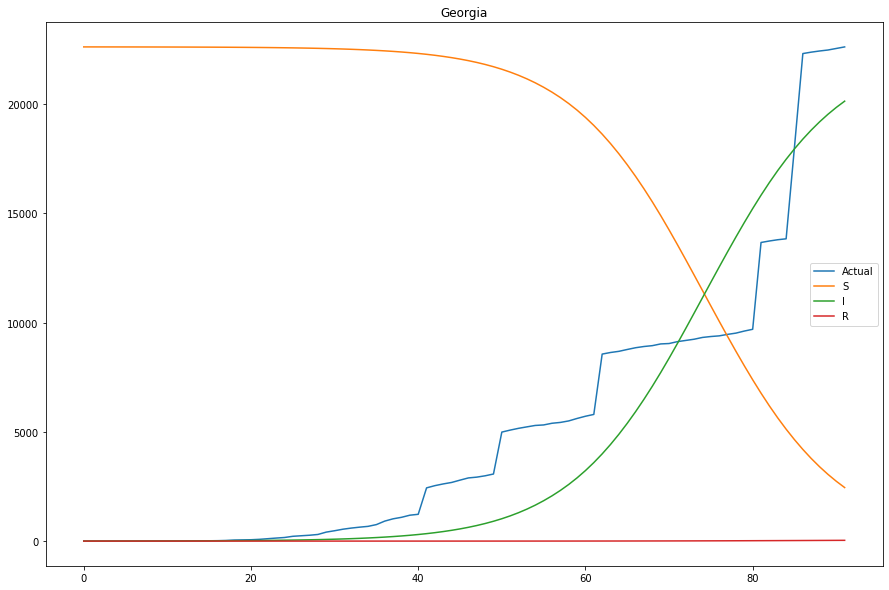

In [100]:
S_0 = 22618
I_0 = 2
R_0 = 0


learner.train()


**These are p'**


**So, alpha = 0.1**


**beta = 5.5611221822097535e-06**



**gamma: 8.766554701949887e-05**



**So D_{reported} = alpha * D'

In [107]:
beta = 5.5611221822097535e-06
gamma = 8.766554701949887e-05

In [128]:
state = "Georgia"

data = learner.load_confirmed(state)


extended_actual, prediction = learner.predict(beta, gamma, data)

D_prime = prediction.y[1]

0         0
1         0
2         0
3         0
4         0
      ...  
87    22378
88    22431
89    22476
90    22547
91    22618
Name: Georgia, Length: 92, dtype: int32


In [129]:
D_receiver = (D_prime*alpha).astype(int)

In [130]:
D_receiver

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    1,    1,    1,    1,    1,    1,    2,    2,    2,
          3,    3,    4,    4,    5,    5,    6,    7,    8,    9,   11,
         12,   14,   16,   18,   20,   23,   26,   30,   34,   38,   43,
         49,   55,   63,   71,   80,   90,  102,  115,  129,  146,  164,
        184,  207,  231,  259,  289,  322,  359,  399,  442,  489,  539,
        592,  649,  708,  771,  836,  904,  973, 1043, 1114, 1184, 1254,
       1324, 1391, 1458, 1521, 1583, 1641, 1696, 1747, 1795, 1839, 1880,
       1918, 1953, 1984, 2013])

In [133]:
data_np = data.to_numpy()
data_np

array([    0,     0,     0,     0,     0,     0,     1,     1,     2,
           3,     3,     4,     6,     9,    11,    14,    19,    28,
          48,    55,    62,    80,   109,   138,   164,   219,   244,
         268,   303,   411,   474,   544,   596,   638,   674,   755,
         915,  1020,  1088,  1185,  1226,  2436,  2538,  2617,  2684,
        2790,  2891,  2927,  2988,  3070,  4989,  5080,  5161,  5228,
        5293,  5316,  5393,  5431,  5500,  5613,  5714,  5797,  8559,
        8632,  8685,  8770,  8850,  8906,  8945,  9024,  9042,  9128,
        9184,  9239,  9321,  9363,  9393,  9461,  9519,  9613,  9694,
       13667, 13735, 13793, 13835, 18042, 22313, 22378, 22431, 22476,
       22547, 22618])

In [132]:
D_receiver - data_np

array([     0,      0,      0,      0,      0,      0,     -1,     -1,
           -2,     -3,     -3,     -4,     -6,     -8,    -10,    -13,
          -18,    -27,    -47,    -53,    -60,    -78,   -106,   -135,
         -160,   -215,   -239,   -263,   -297,   -404,   -466,   -535,
         -585,   -626,   -660,   -739,   -897,  -1000,  -1065,  -1159,
        -1196,  -2402,  -2500,  -2574,  -2635,  -2735,  -2828,  -2856,
        -2908,  -2980,  -4887,  -4965,  -5032,  -5082,  -5129,  -5132,
        -5186,  -5200,  -5241,  -5324,  -5392,  -5438,  -8160,  -8190,
        -8196,  -8231,  -8258,  -8257,  -8237,  -8253,  -8206,  -8224,
        -8211,  -8196,  -8207,  -8179,  -8139,  -8137,  -8128,  -8155,
        -8173, -12084, -12094, -12097, -12088, -16247, -20474, -20498,
       -20513, -20523, -20563, -20605])